In [68]:
#Package calls
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

            Week   Sales
Date                    
2021-01-03     0   55429
2021-01-10     1  157706
2021-01-17     2  116824
2021-01-24     3  127530
2021-01-31     4  132029


<Axes: xlabel='Date'>

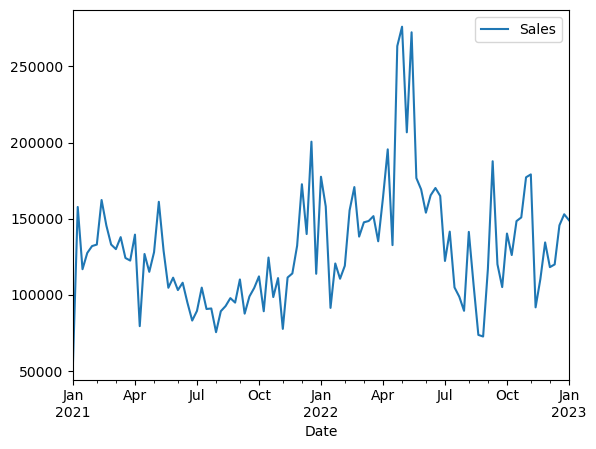

In [4]:
df = pd.read_csv("weekly_sales.csv")

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='raise')
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
print(df.head()) 

df = df.drop('Week', axis=1)

df.plot()

In [6]:
# Determine the cutoff date for 18 months of data
cutoff_date = df.index.min() + pd.DateOffset(months=18)

# Split the data
train = df[df.index < cutoff_date]
test = df[df.index >= cutoff_date]
total = df[df.index <= cutoff_date]

# Display the split data
print(f"Training data:\n{train.head()}")
print(f"Testing data:\n{test.head()}")

Training data:
             Sales
Date              
2021-01-03   55429
2021-01-10  157706
2021-01-17  116824
2021-01-24  127530
2021-01-31  132029
Testing data:
             Sales
Date              
2022-07-03  122264
2022-07-10  141516
2022-07-17  104862
2022-07-24   98781
2022-07-31   89513


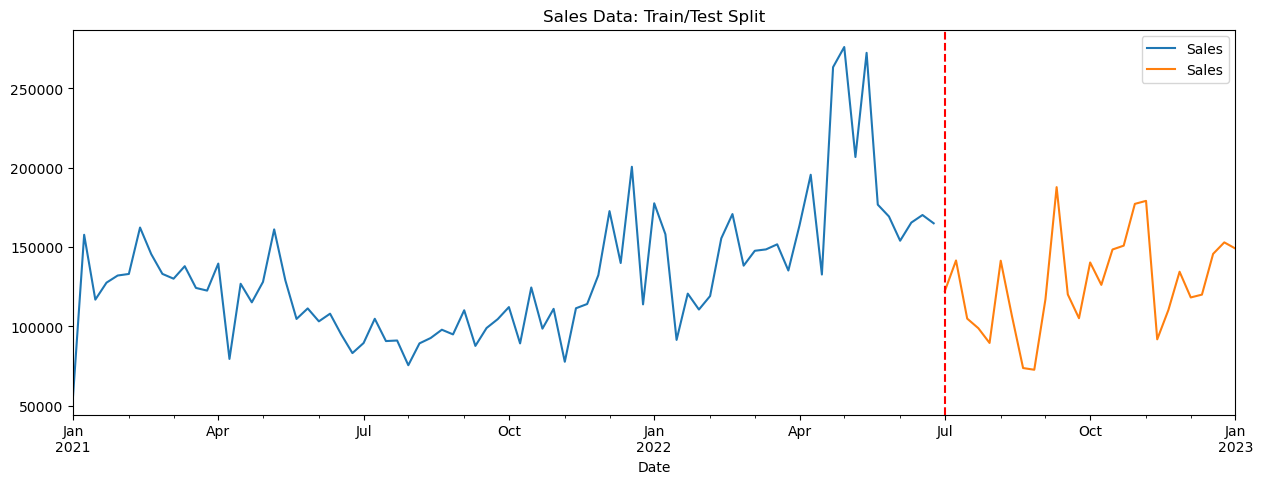

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Training Set")
test.plot(ax=ax, label="Test Set")
ax.axvline(cutoff_date, color='red', ls='--')

plt.title("Sales Data: Train/Test Split")
plt.legend()
plt.show()

In [10]:
# # Extracting date-related features
# df['Weekday'] = df.index.weekday  # Weekday: 0=Monday, 6=Sunday
# df['Month'] = df.index.month      # Month: 1=January, 12=December
# df['Year'] = df.index.year        # Year
# df['Week'] = df.index.isocalendar().week  # ISO Week number

# # Lag feature: Previous week's sales
# df['Lag_1'] = df['Sales'].shift(1)

# # Drop rows with missing values that result from shifting or date extraction
# df = df.dropna()

# # Features (X) and target (y)
# X = df[['Weekday', 'Month', 'Year', 'Week', 'Lag_1']]  # All the date-related features and the lag
# y = df['Sales']  # The target is sales

In [12]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    
    df = df.copy()
    #df['Weekday'] = df.index.weekday
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Week'] = df.index.isocalendar().week
    df['Lag_1'] = df['Sales'].shift(1)
    df = df.dropna()
    return df

df = create_features(df)

In [14]:
FEATURES = ['Month', 'Year', 'Week', 'Lag_1']
TARGET = ['Sales']

In [16]:
train = create_features(train)
test = create_features(test)

In [18]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

print(X_train.head())
print(y_train.head())

            Month  Year  Week     Lag_1
Date                                   
2021-01-10      1  2021     1   55429.0
2021-01-17      1  2021     2  157706.0
2021-01-24      1  2021     3  116824.0
2021-01-31      1  2021     4  127530.0
2021-02-07      2  2021     5  132029.0
             Sales
Date              
2021-01-10  157706
2021-01-17  116824
2021-01-24  127530
2021-01-31  132029
2021-02-07  133011


# SVM IMPLEMENTATION

In [62]:
supportVectorReg = SVR(kernel='linear', C=80, epsilon=0.50)

In [64]:
supportVectorReg.fit(X_train, y_train.values.ravel())

SVR(C=80, epsilon=0.5, kernel='linear')

Feature: Month, Coefficient: 1053.97528
Feature: Year, Coefficient: 362.44598
Feature: Week, Coefficient: 1464.09278
Feature: Lag_1, Coefficient: 1.17171


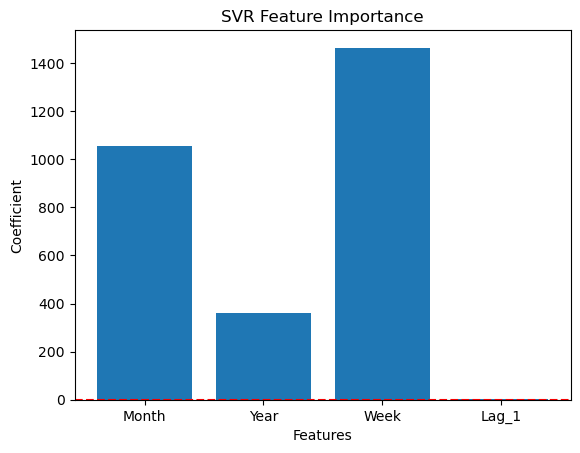

In [70]:
# Get the coefficients
importance = supportVectorReg.coef_.ravel()  # Flatten to 1D if necessary

# Print feature importance
for i, v in enumerate(importance):
    print(f'Feature: {FEATURES[i]}, Coefficient: {v:.5f}')

# Plot feature importance
plt.bar(np.arange(len(importance)), importance, tick_label=FEATURES)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('SVR Feature Importance')
plt.axhline(0, color='red', linestyle='--')  # Add reference line at 0
plt.show()

In [72]:
predSVR = supportVectorReg.predict(X_test)
test['Predictions_SVR'] = predSVR


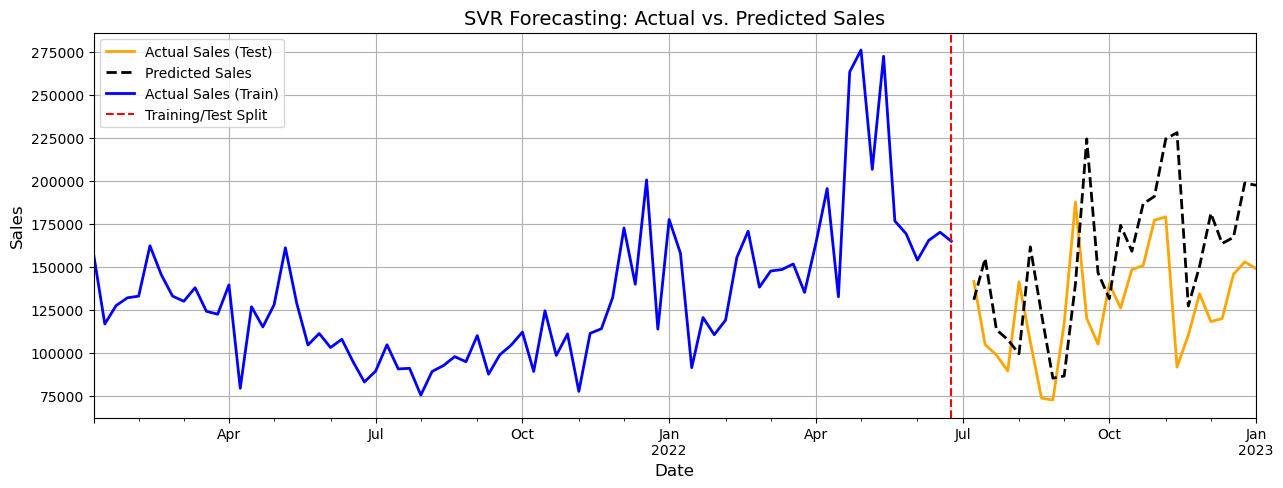

In [74]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5))

# Plot actual sales (test data)
test['Sales'].plot(ax=ax, label="Actual Sales (Test)", color='orange', linewidth=2)

# Plot predicted sales (test data)
test['Predictions_SVR'].plot(ax=ax, label="Predicted Sales", color='black', linestyle='--', linewidth=2)

# Plot actual sales (training data)
train['Sales'].plot(ax=ax, label="Actual Sales (Train)", color='blue', linewidth=2)

# Add a vertical line to mark the training/testing split
cutoff_date = train.index[-1]  # Use the last date from the training set
ax.axvline(cutoff_date, color='red', linestyle='--', label='Training/Test Split')

# Add labels, title, and legend
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.title("SVR Forecasting: Actual vs. Predicted Sales", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

In [76]:
#Evaluation Metric
rmse_SVR = root_mean_squared_error(y_test, predSVR)
mape_SVR = mean_absolute_percentage_error (y_test, predSVR)


print(f'The Root Mean Square Error (RMSE) is {rmse_SVR}')
print(f'Mean Absolute Percentage Error (MAPE) is {mape_SVR}')

The Root Mean Square Error (RMSE) is 48913.91427621589
Mean Absolute Percentage Error (MAPE) is 0.3400150540224833


# LINEAR REGRESSION IMPLEMENTATION

In [36]:
linearReg = LinearRegression()

In [38]:
linearReg.fit(X_train, y_train.values.ravel())

LinearRegression()

Feature: 0, Score: -2302.89278
Feature: 1, Score: 27101.06237
Feature: 2, Score: 519.08850
Feature: 3, Score: 0.44659


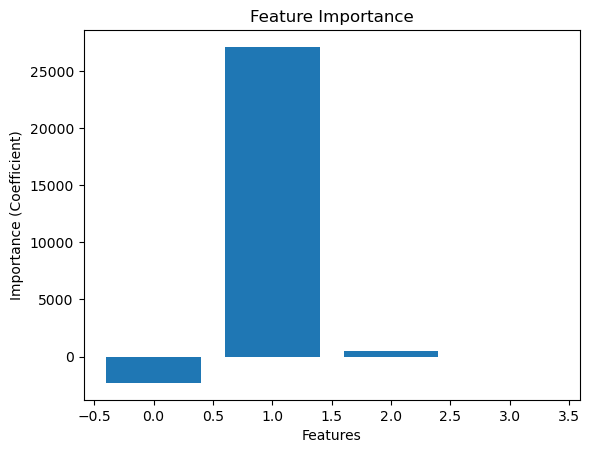

In [40]:
# Extract coefficients from the model
importance = linearReg.coef_.ravel()  # Flatten the array to 1D if necessary

# Print feature importance
for i, v in enumerate(importance):
    print(f'Feature: {i}, Score: {v:.5f}')

# Plot feature importance
import matplotlib.pyplot as plt  # Ensure matplotlib is imported

plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Features')
plt.ylabel('Importance (Coefficient)')
plt.title('Feature Importance')
plt.show()


In [42]:
predLR = linearReg.predict(X_test)
test['Predictions_LR'] = predLR

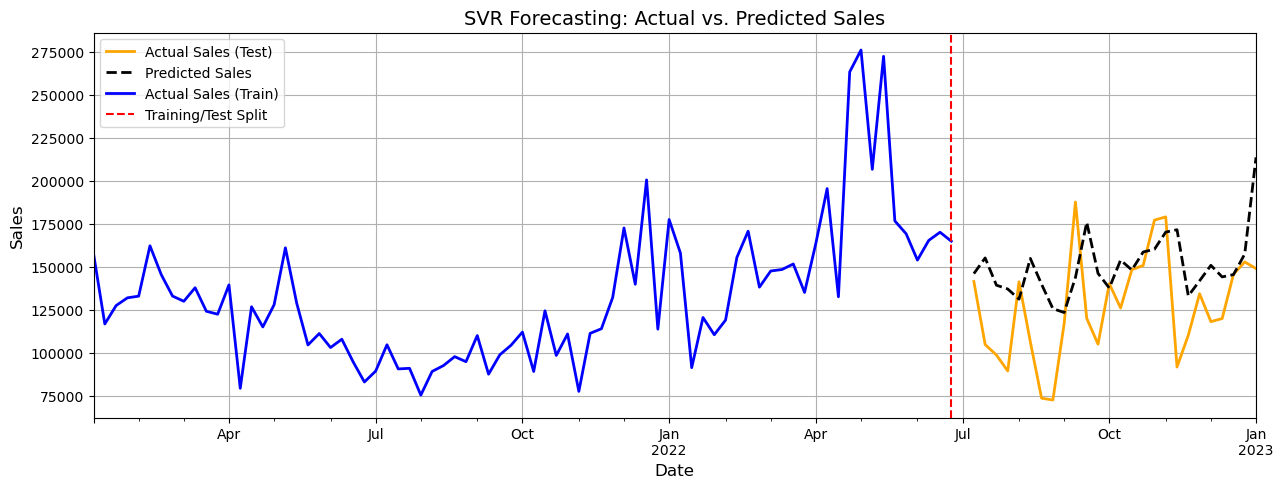

In [44]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5))

# Plot actual sales (test data)
test['Sales'].plot(ax=ax, label="Actual Sales (Test)", color='orange', linewidth=2)

# Plot predicted sales (test data)
test['Predictions_LR'].plot(ax=ax, label="Predicted Sales", color='black', linestyle='--', linewidth=2)

# Plot actual sales (training data)
train['Sales'].plot(ax=ax, label="Actual Sales (Train)", color='blue', linewidth=2)

# Add a vertical line to mark the training/testing split
cutoff_date = train.index[-1]  # Use the last date from the training set
ax.axvline(cutoff_date, color='red', linestyle='--', label='Training/Test Split')

# Add labels, title, and legend
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.title("SVR Forecasting: Actual vs. Predicted Sales", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

In [46]:
#Evaluation Metric
rmse_LR = root_mean_squared_error(y_test, predLR)
mape_LR = mean_absolute_percentage_error (y_test, predLR)


print(f'The Root Mean Square Error (RMSE) is {rmse_LR}')
print(f'Mean Absolute Percentage Error (MAPE) is {mape_LR}')

The Root Mean Square Error (RMSE) is 37682.354953832895
Mean Absolute Percentage Error (MAPE) is 0.2795873253406658


# Random Forest Implementations

In [49]:
randomForestModel = RandomForestRegressor(n_estimators=1000, max_features=4, random_state=1)

In [51]:
randomForestModel.fit(X_train, y_train)

C:\Users\ACER\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_features=4, n_estimators=1000, random_state=1)

Feature: 0, Score: 0.05718
Feature: 1, Score: 0.12890
Feature: 2, Score: 0.23872
Feature: 3, Score: 0.57519


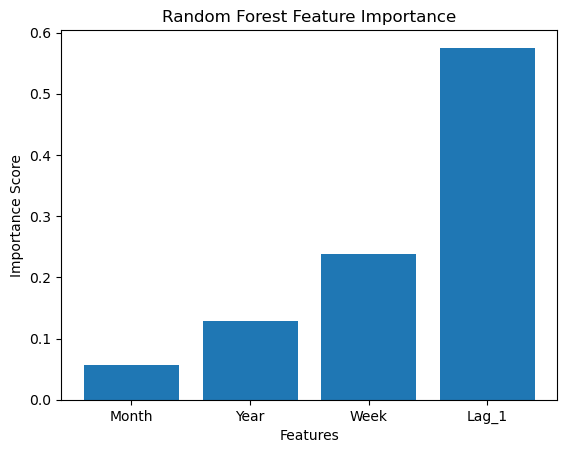

In [52]:
# Get feature importance
importance = randomForestModel.feature_importances_

# Print feature importance
for i, v in enumerate(importance):
    print(f'Feature: {i}, Score: {v:.5f}')

# Plot feature importance
plt.bar([x for x in range(len(importance))], importance, tick_label=FEATURES)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Random Forest Feature Importance')
plt.show()

In [55]:
predRF = randomForestModel.predict(X_test)


test["Predictions_RF"] = predRF

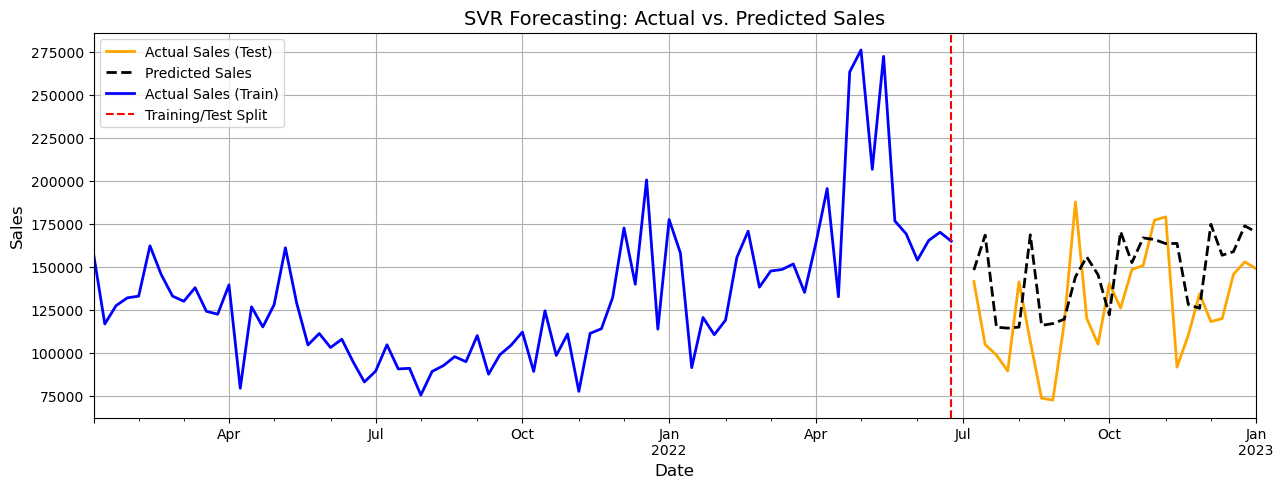

In [57]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5))

# Plot actual sales (test data)
test['Sales'].plot(ax=ax, label="Actual Sales (Test)", color='orange', linewidth=2)

# Plot predicted sales (test data)
test['Predictions_RF'].plot(ax=ax, label="Predicted Sales", color='black', linestyle='--', linewidth=2)

# Plot actual sales (training data)
train['Sales'].plot(ax=ax, label="Actual Sales (Train)", color='blue', linewidth=2)

# Add a vertical line to mark the training/testing split
cutoff_date = train.index[-1]  # Use the last date from the training set
ax.axvline(cutoff_date, color='red', linestyle='--', label='Training/Test Split')

# Add labels, title, and legend
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.title("SVR Forecasting: Actual vs. Predicted Sales", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

In [59]:
#Evaluation Metric
rmse_RF = root_mean_squared_error(y_test, predRF)
mape_RF = mean_absolute_percentage_error (y_test, predRF)


print(f'The Root Mean Square Error (RMSE) is {rmse_RF}')
print(f'Mean Absolute Percentage Error (MAPE) is {mape_RF}')

The Root Mean Square Error (RMSE) is 35194.10999879019
Mean Absolute Percentage Error (MAPE) is 0.26590234762467396
